# Ames Housing Prices

## Purpose of the Analysis:

### Find out which Variables Strongly Affect the Housing Prices

The goal of this project is to determine which variables most strongly correlate to the housing prices in Ames, Iowa. The parts of the notebook is split into the EDA, Feature Engineering, and Modeling where regression will be conducted. Three types of regression will be conducted (Ordinary Least Square, Ridge Regression, and Lasso Regression). The root means squared error will be used to determine the training error, cross validation error, and test error.

The file codebook.txt in the repository gives a description of what each independent variable is in the data.

Some of the ideas presented in this project comes from the Data 200 course at UC Berkeley. The link to the course is here: http://www.ds100.org/su20/

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')
training_data, test_data = train_test_split(full_data, random_state=42, test_size=0.2)

full_data.shape

(2000, 82)

## EDA

First, we will see the amount of missing data in each column and drop those that have too many to the point where it isn't meaningful to analyze them.

In [2]:
#Remove features with lots of NA
nanmean=training_data.isna().mean()*100
nan=nanmean[nanmean>25].sort_values(ascending=False)
print(nan)

training_data.drop(columns=nan.index,inplace=True)

Pool_QC         99.5000
Misc_Feature    96.0000
Alley           93.9375
Fence           80.6250
Fireplace_Qu    48.6875
dtype: float64


C:\Users\bench\Anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The joint plot was made to see if there are outliers. There are outliers present when the sales price is large and where the living area is greater than 500 sq. ft.

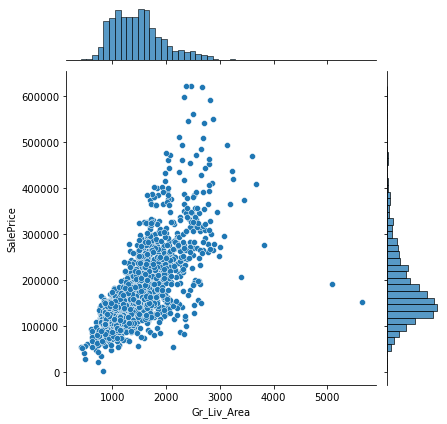

In [3]:
#outliers for living area vs price

training_data.columns.values

sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
);

In [4]:
#2 SD for sales price

salepricemean=np.mean(training_data['SalePrice'])
salepricestd=np.std(training_data['SalePrice'])

print('Mean Sales Price: ', salepricemean)
print('STD Sales Price: ', salepricestd)

salepricerange=(salepricemean-(2*salepricestd),salepricemean+(2*salepricestd))
salepricerange

Mean Sales Price:  181503.679375
STD Sales Price:  81770.00223512761


(17963.67490474478, 345043.68384525523)

Upon looking at the data more, outliers exists when the Gr_Liv_Area is greater than 5,000 because they were partial sales. Therefore, it is in our interest to remove the outliers so our regression can fit more accurately.

Text(0, 0.5, 'Frequency')

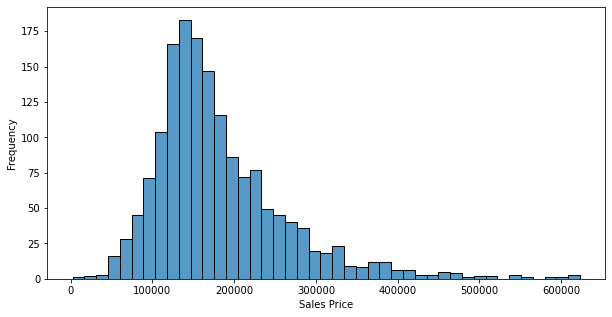

In [5]:
plt.figure(figsize=(10,5))
sns.histplot(training_data, x='SalePrice')
plt.xlabel("Sales Price")
plt.ylabel("Frequency")

In [6]:
#check outliers

training_data.loc[training_data['Gr_Liv_Area']>4000,['Gr_Liv_Area','SalePrice']]

,Gr_Liv_Area,SalePrice
1471,5095,190950
1014,5642,152200


In [7]:
def remove_outliers(data, variable, upper):
    return data.loc[(data[variable] < upper), :]

training_data = remove_outliers(training_data, 'Gr_Liv_Area', 4000)

The type of data in each variable will help determine how we will manipulate each variable.

In [8]:
training_data.dtypes.value_counts()

object     38
int64      30
float64     9
dtype: int64

The distribution of neighborhoods in the data might give us something insightful. We see that most of the houses reside in the Ames area, which is expected.

<AxesSubplot:xlabel='Neighborhood'>

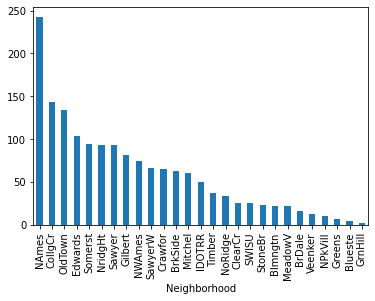

In [9]:
training_data.groupby('Neighborhood').size().sort_values(ascending=False).plot(kind='bar')

The correlation between the Sales Price and the numerical variables will help determine which variables to choose in our linear regression. One thing to keep in mind is colinearity within the data. This will be addressed later in the notebook.

Text(0, 0.5, 'Feature')

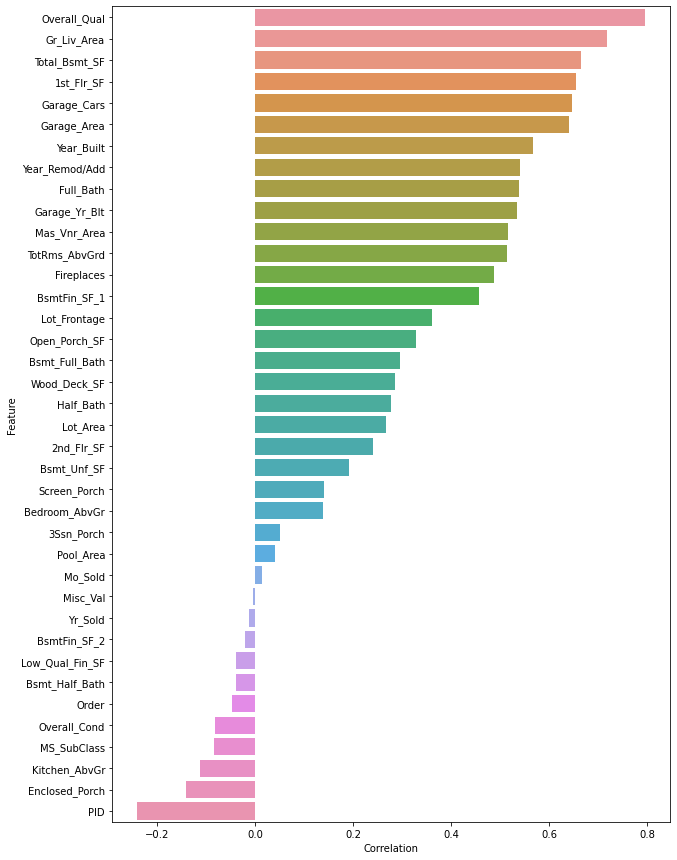

In [10]:
num_cols = training_data.dtypes[(training_data.dtypes == 'int64') | (training_data.dtypes == 'float64')].index
corr_df = training_data.loc[:,num_cols].corr()

sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis=0).sort_values(ascending=False)
ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(y=sale_price_corr.keys(),x=sale_price_corr.values)
plt.xlabel("Correlation")
plt.ylabel("Feature")

There is some interesting remarks from the barplot. Intuitively, one can expect that if there are more bedrooms, the sale price will be higher. However, from creating a scatter plot, there doesn't seem to be a clear correlation. 

<AxesSubplot:xlabel='Bedroom_AbvGr', ylabel='SalePrice'>

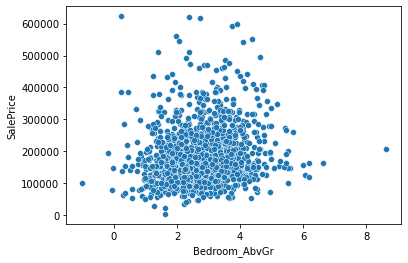

In [11]:
noise = np.random.normal(0,0.5,training_data.shape[0])
training_data_2=training_data
training_data_2['Bedroom_AbvGr']=training_data_2['Bedroom_AbvGr']+noise
sns.scatterplot(data=training_data_2,x='Bedroom_AbvGr',y='SalePrice')

The overall quality of the house (rated 1-10) seemed to have the highest correlation. Let's see how the scatter plot looks like.

<AxesSubplot:xlabel='Overall_Qual', ylabel='SalePrice'>

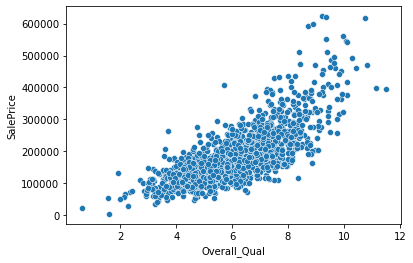

In [12]:
training_data_2=training_data
training_data_2['Overall_Qual']=training_data_2['Overall_Qual']+noise
sns.scatterplot(data=training_data_2,x='Overall_Qual',y='SalePrice')

Text(0, 0.5, 'Frequency')

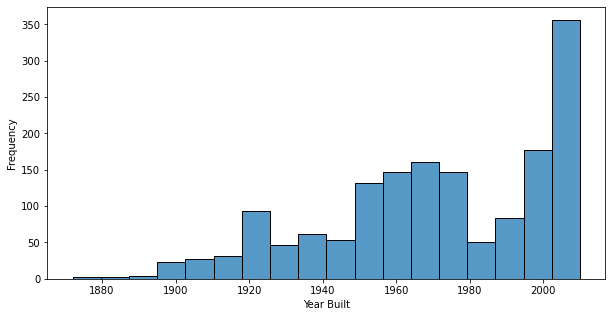

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(training_data, x='Year_Built')
plt.xlabel('Year Built')
plt.ylabel("Frequency")

## Feature Engineering

We will now explore variables where feature engineering is required.

Given the number of variables that show the quantity of bathrooms, we can combine it into a variable with the total number of bathrooms as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

*Idea from Data 200 Notebook

In [14]:
def add_total_bathrooms(data):
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms['TotalBathrooms']=with_bathrooms[bath_vars].fillna(0)@weights
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

A scatter plot was created to show there was a positive correlation between the number of total bathrooms and the sale price.

<AxesSubplot:xlabel='TotalBathrooms', ylabel='SalePrice'>

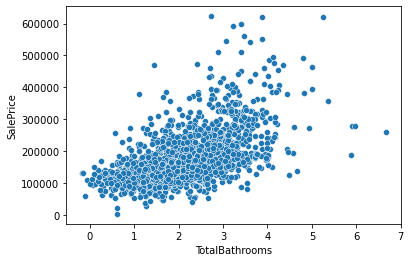

In [15]:
training_data_2=training_data
training_data_2['TotalBathrooms']=training_data_2['TotalBathrooms']+noise
sns.scatterplot(data=training_data_2,x='TotalBathrooms',y='SalePrice')

In [16]:
def add_total_SF(data):
    totalSFdf = data.copy()
    totalSFdf['Total_SF'] = totalSFdf['Total_Bsmt_SF'] + totalSFdf['Gr_Liv_Area']
    return totalSFdf

training_data = add_total_SF(training_data)

Text(0, 0.5, 'Frequency')

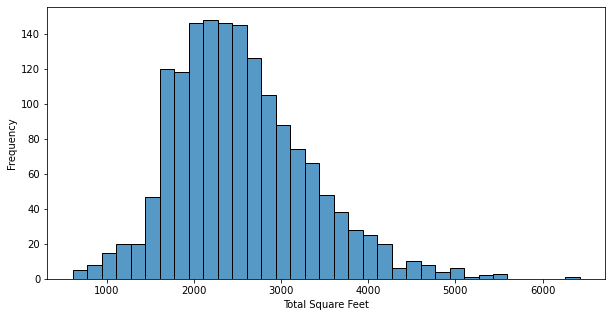

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(training_data, x='Total_SF')
plt.xlabel('Total Square Feet')
plt.ylabel("Frequency")

Next, houses that are in rich neighborhoods are likely to be more expensive. From grouping the data by the neighborhoods, there are four distinct neighborhoods that have the largest sales price, followed by a small dropoff. 

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000., 400000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

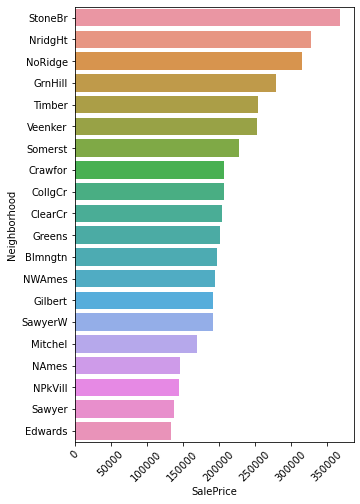

In [18]:
def find_rich_neighborhoods(data, n=3, metric=np.mean):
    neighborhoods = data.groupby('Neighborhood').agg(metric).sort_values('SalePrice',ascending=False).iloc[0:n].index.tolist()
    return neighborhoods

richhoods=training_data.groupby('Neighborhood').agg(np.mean).sort_values('SalePrice',ascending=False).iloc[0:20]
plt.subplots(figsize=(5,8))
sns.barplot(y=richhoods.index,x=richhoods.SalePrice)
plt.xticks(rotation=45)

The following will add a one hot encoding feature of the four wealthiest neighborhood to the dataset.

In [19]:
def add_in_rich_neighborhood(data, neighborhoods):
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype(int)
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 4, np.mean)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

One hot encoding will be used for categorical variables. The following is a function that will one hot encode variables.

In [20]:
categorical = (training_data.dtypes == "object")
categorical_list = list(categorical[categorical].index)
print(categorical_list)

def encode(data):
    categorical = (data.dtypes == "object")
    categorical_list = list(categorical[categorical].index)
    for i in categorical_list:
        encode=preprocessing.LabelEncoder()
        data[i]=encode.fit_transform(data[i])
    return data
training_data=encode(training_data)

['MS_Zoning', 'Street', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style', 'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Sale_Type', 'Sale_Condition']


To lower the error of our fit, it is best to optimize the amount of variables we add to our regression model. The following will test the bounds of our cross-validation error by adding variables to our model before the cross-validation error increases (i.e. bias-variance tradeoff).

The following code will only factor in numberical variables. The RMSE is plotted for each addition of a variable.

The plot illustrates that the RMSE decreases up until the 15th feature. After that, the RMSE flattens out and then slightly decreases further. Therefore, choosing 10-15 variables is optimal to lower the RMSE and to prevent a low bias and high variance.

*Idea from Data 200*

[44046.42685420158, 36954.282278527426, 36879.389740002305, 36688.737934277146, 34635.15699492282, 33317.13719391279, 32893.66253176395, 32892.11660138001, 32364.603401516033, 32105.52229150128]


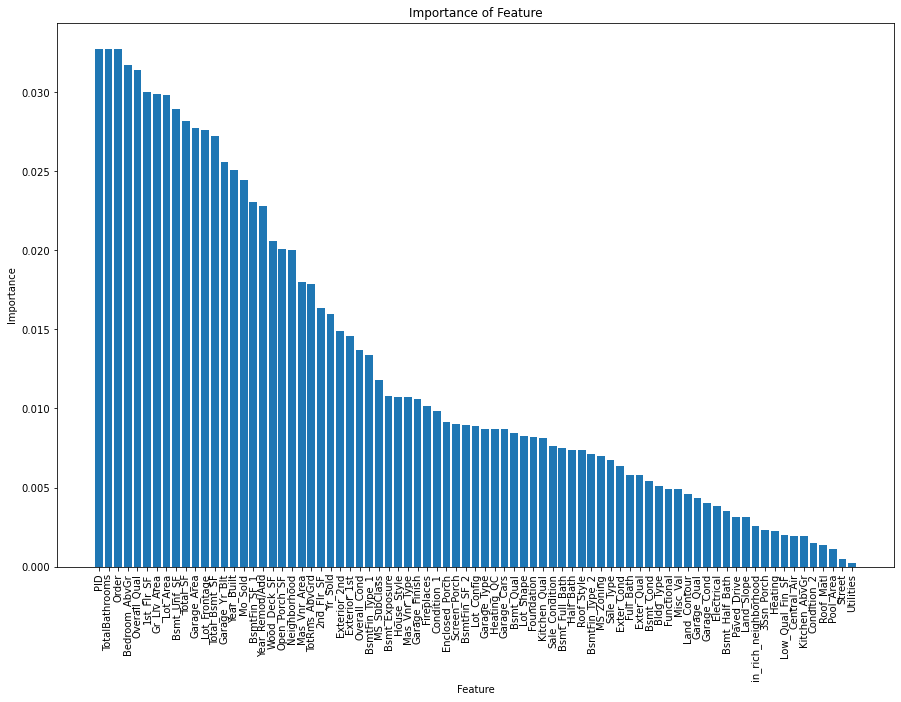

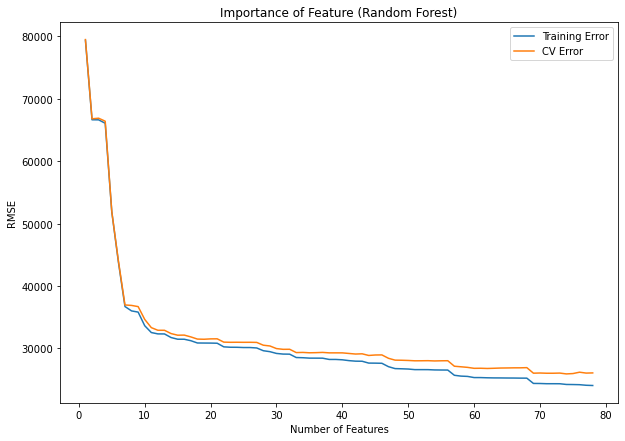

In [21]:
#Feature Importance (RF)

X=training_data.drop(columns=['SalePrice'])
Y=training_data['SalePrice']

for i in range(len(num_cols)-1):
    meanvar=np.nanmean(X[num_cols[i]])
    X[num_cols[i]].fillna(meanvar,inplace=True)

X=X.fillna(method="pad")

clf = ensemble.RandomForestClassifier()
clf = clf.fit(X, Y)
features = X.columns
importances = clf.feature_importances_
idxrf = np.argsort(importances)[::-1]

plt.figure(figsize=(15,10))
plt.bar(np.arange(len(idxrf)),importances[idxrf])
plt.xticks(range(len(idxrf)), [features[i] for i in idxrf], rotation='vertical')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Importance of Feature')

#number of features based on trees

features=79
rmse = np.zeros(features-1)

# loop over the Ks

train_error_vs_N = []
cv_error_vs_N = []

for i in range(1,features):
    trainingx=X.iloc[:,idxrf[0:i]]
    trainingy=Y

    linear_model=lm.LinearRegression()
    
    cv_results = cross_validate(linear_model, trainingx, trainingy, 
                                cv=5,scoring=('r2', 'neg_root_mean_squared_error'),
                                return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)

plt.figure(figsize=(10,7))
sns.lineplot(np.arange(1,features), train_error_vs_N)
sns.lineplot(np.arange(1,features), cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");
plt.title('Importance of Feature (Random Forest)')

print(cv_error_vs_N[5:15])

numfeaturesrf=20

      Iter       Train Loss   Remaining Time 
         1           0.5895           11.27m
         2         268.0072           11.74m
         3         267.8540           11.61m
         4         267.8502           11.33m
         5         267.8473           10.93m
         6         267.8451           10.47m
         7         267.8433            9.97m
         8         267.8419            9.45m
         9         267.8408            8.94m
        10         267.8399            8.39m
        11         267.8392            7.85m
        12         267.8386            7.31m
        13         267.8381            6.76m
        14         267.8377            6.20m
        15         267.8374            5.63m
        16         267.8371            5.08m
        17         267.8369            4.51m
        18         267.8367            3.95m
        19         267.8366            3.39m
        20         267.8365            2.82m
        21         267.8364            2.26m
        2

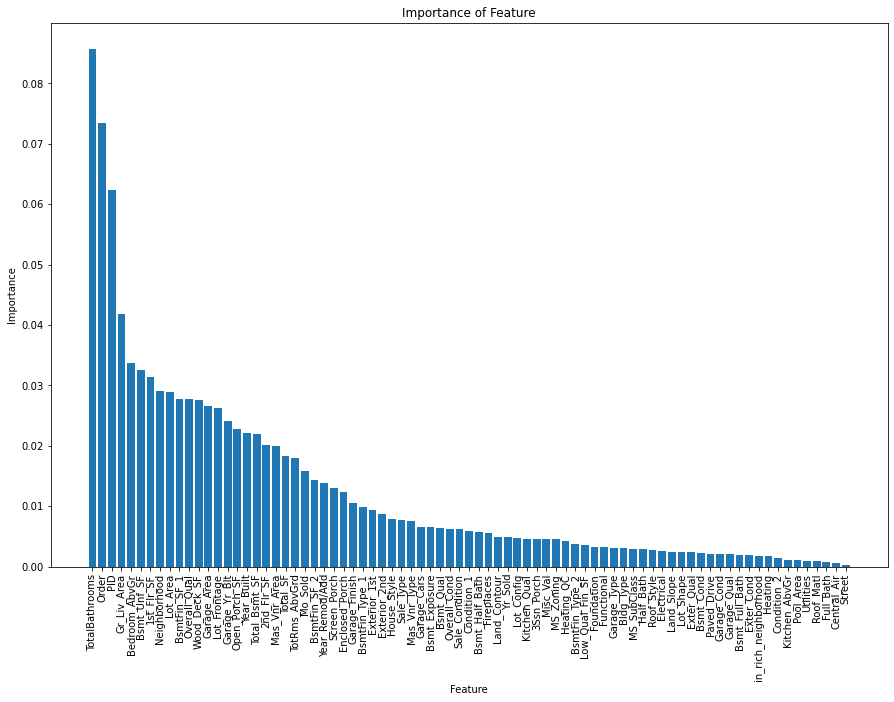

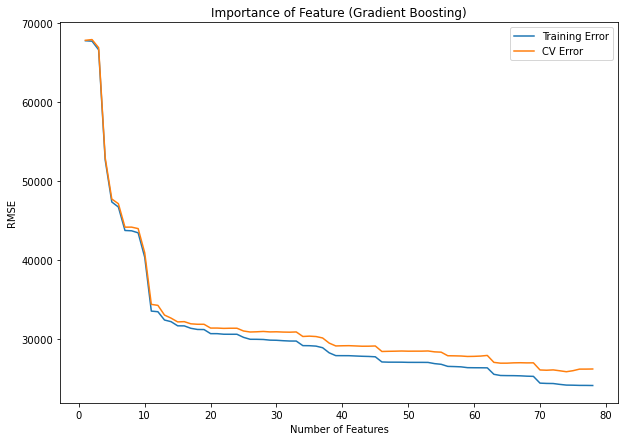

In [22]:
#Feature Importance (Gradient Boosting)

clf = ensemble.GradientBoostingClassifier(n_estimators=25,verbose=3)
clf = clf.fit(X, Y)
features = X.columns
importances = clf.feature_importances_
idxgb = np.argsort(importances)[::-1]

plt.figure(figsize=(15,10))
plt.bar(np.arange(len(idxgb)),importances[idxgb])
plt.xticks(range(len(idxgb)), [features[i] for i in idxgb], rotation='vertical')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Importance of Feature')

#number of features based on gb

features=79
rmse = np.zeros(features-1)

# loop over the Ks

train_error_vs_N = []
cv_error_vs_N = []

for i in range(1,features):
    trainingx=X.iloc[:,idxgb[0:i]]
    trainingy=Y

    linear_model=lm.LinearRegression()
    
    cv_results = cross_validate(linear_model, trainingx, trainingy, 
                                cv=5,scoring=('r2', 'neg_root_mean_squared_error'),
                                return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)

plt.figure(figsize=(10,7))
sns.lineplot(np.arange(1,features), train_error_vs_N)
sns.lineplot(np.arange(1,features), cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");
plt.title('Importance of Feature (Gradient Boosting)')

print(cv_error_vs_N[10:20])

numfeaturesgb=20

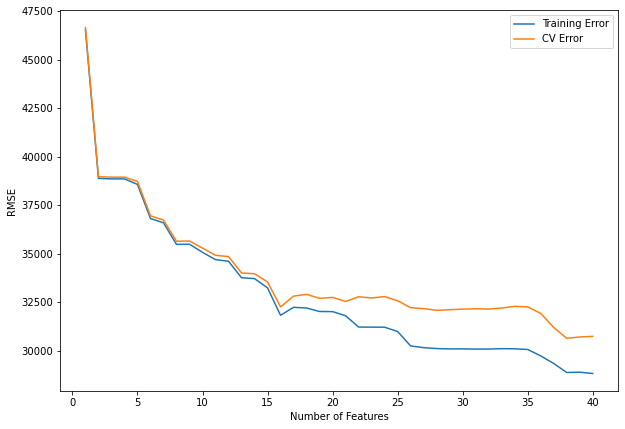

In [23]:
#number of features based on corr

train_error_vs_N = []
cv_error_vs_N = []
linear_model=lm.LinearRegression()

num_cols = training_data.dtypes[(training_data.dtypes == 'int64') | (training_data.dtypes == 'float64')].index
corr_df = training_data.loc[:,num_cols].corr()
sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis=0).sort_values(ascending=False)

range_of_num_features = range(1, sale_price_corr.shape[0] + 1)

for N in range_of_num_features:
    sale_price_corr_first_N_features = sale_price_corr.iloc[:N]
    saleprice=training_data['SalePrice'].drop(training_data.index
                                              [training_data[sale_price_corr.iloc[:N].index]
                                               .isnull().any(1)])
    indepVar=training_data[sale_price_corr_first_N_features.index].dropna()
    
    scaler=preprocessing.StandardScaler()
    indepVar = pd.DataFrame(scaler.fit_transform(indepVar),columns = indepVar.columns)
    
    cv_results = cross_validate(linear_model, indepVar, saleprice, cv=4,
                                scoring=('r2', 'neg_root_mean_squared_error'),
                                return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)

plt.figure(figsize=(10,7))
sns.lineplot(range_of_num_features, train_error_vs_N)
sns.lineplot(range_of_num_features, cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");

Further illustration shows exactly where the dip occurs before the RMSE rises again. The valley seems to occur on the 14th variable.

In [24]:
print(cv_error_vs_N[10:20])

numfeaturescorr=16

[34912.27453128845, 34846.9433365312, 34002.21716559507, 33962.71729812126, 33537.34856910285, 32253.143713318816, 32809.72245380283, 32900.145804088854, 32694.276070316875, 32742.962782385526]


From the 14 variables, it is important to take out variables that are dependent on each other. A heat map with the correlation between the variables were made. 

For example, the amount of cars you can fit into a garage is highly correlated to the garage area, which makes sense. Therefore, we need to delete one of the variables.

<AxesSubplot:>

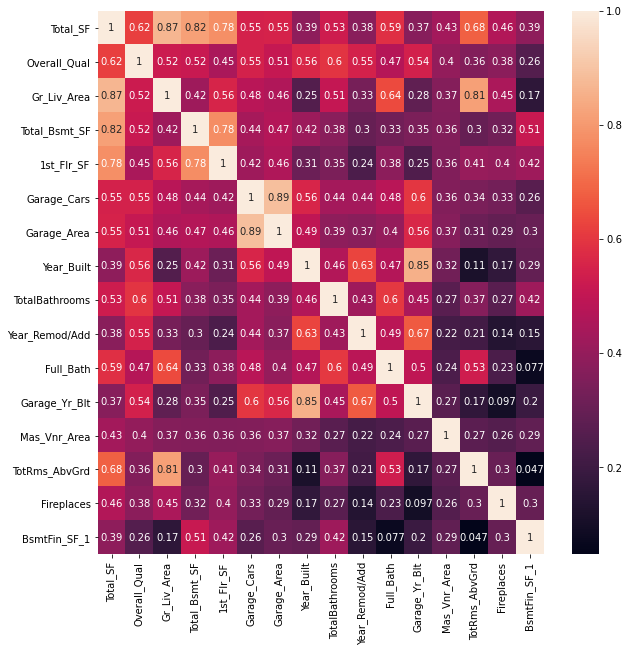

In [25]:
#multicorr test

features=sale_price_corr.iloc[:numfeaturescorr]

plt.figure(figsize=(10,10))
sns.heatmap(training_data[features.index].corr(),annot=True)

From observing the heat map, there were 5 variables that I decided to take out to minimize multicollinearity.

In [26]:
colinear=['TotRms_AbvGrd','Garage_Area','Year_Remod/Add','Full_Bath','Garage_Yr_Blt']

idxcorr=[]

for i in range(len(features.index.to_list())):
    idxcorr.append(training_data.columns.get_loc(sale_price_corr.index.to_list()[i]))
idxcorr.insert(0,76)
idxcorr=np.array(idxcorr)

## Modeling

We will define our pipeline to create the dataframe that will be passed into the regression models.

*Idea from Data 200*

In [27]:
def select_columns(data, columns):
    """Select only columns passed as arguments."""
    return data.iloc[:, columns]

def process_data_fm(data, overall_features):
    data = remove_outliers(data, 'Gr_Liv_Area', 4000)
    data = add_total_bathrooms(data)
    
    # Transform Data, Select Features
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, overall_features)
        
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    
    numf=X.dtypes[(X.dtypes == 'int64') | (X.dtypes == 'float64')].index
    scaler=preprocessing.StandardScaler()
    X.loc[:,numf] = scaler.fit_transform(X.loc[:,numf])
    X = encode(X)
    
    y = data.loc[:, 'SalePrice']
    X=X.fillna(method="pad")
    X=X.fillna(method="bfill")
    return X, y

### Ordinary Least Square

The first type of regression that will be conducted is the ordinary least square. 

The data was read in again and if there is no data in any of the 14 numerical columns we chose, the observation was removed. The data was then split into the test and training data.

In [28]:
def OLSrun(X_train_n, y_train, X_test_n, y_test):  

    final_model = lm.LinearRegression()
    final_model.fit(X_train_n, y_train)
    y_predicted_train = final_model.predict(X_train_n)
    y_predicted_test = final_model.predict(X_test_n)
    
    training_rmse = metrics.mean_squared_error(y_predicted_train, y_train,squared=False)
    test_rmse = metrics.mean_squared_error(y_predicted_test, y_test,squared=False)
    print('Training and Test Error:',round(training_rmse,2),round(test_rmse,2))
    
    #Line Plot
    plt.figure(figsize=(10,7))
    ax=sns.scatterplot(y_predicted_train,y_train,label="Training")
    sns.scatterplot(y_predicted_test,y_test,label="Test",ax=ax)
    sns.lineplot([0,600000],[0,600000],color='red')
    
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('Actual Sales Price')
    ax.legend(loc='upper left')
    plt.show()
    
    #Residual Plots
    plt.figure(figsize=(10,7))
    ax=sns.residplot(y_predicted_train,y_train,label="Training")
    sns.residplot(y_predicted_test,y_test,label="Test",ax=ax)
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('RMSE')
    plt.title('Residual Plot')
    ax.legend(loc='upper left')
    plt.show()

Only 19 rows were removed out of 2,000, which won't affect our analysis.

Both the training and test data will be processed into our pipeline that we defined earlier.

The training data was fitted into our linear regression model and from that the predicted training and test sales prices was determined.

The RMSE of the test and training dataset was calculated.

A residual plot of the RMSE and Predicted Sales Price shows that in general the regression was fine except for predicted sales price greater than 40,000, where there is a large absolute RMSE.

The predicted and actual sales price for the test dataset is plotted. There are a few outliers above the true sales price of 500,000.

### Ridge Regression

The second type of regression that will be implemented is the ridge regression. Since the regularization parameter depends on the coefficents of our regression, the data has to be standardized to prevent one feature from being overrepresented.

In [29]:
def ridgerun(X_train_n, y_train_n, X_test_n, y_test_n):
    
    param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
    final_ridge = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
    final_ridge.fit(X_train_n, y_train_n)
    alpha = final_ridge.best_params_['alpha']
    print('Initial Best Alpha', alpha)
    
    param_gridimp = {'alpha': list(np.linspace(alpha-(alpha*0.2),alpha+(alpha*0.2),200))}
    final_ridgeimp = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
    final_ridgeimp.fit(X_train_n, y_train_n)
    alphaimp = final_ridgeimp.best_params_['alpha']
    print('Improved Best Alpha', round(alphaimp,2))
    
    
    y_ridge_train = final_ridgeimp.predict(X_train_n)
    y_ridge_test = final_ridgeimp.predict(X_test_n)
    
    training_rmse = metrics.mean_squared_error(y_ridge_train, y_train_n,squared=False)
    test_rmse = metrics.mean_squared_error(y_ridge_test, y_test_n,squared=False)
    print('Training and Test Error:',round(training_rmse,2),round(test_rmse,2))
    
    
    #Line Plot
    plt.figure(figsize=(10,7))
    
    ax=sns.scatterplot(y_ridge_train,y_train_n,label="Training")
    sns.scatterplot(y_ridge_test,y_test_n,label="Test",ax=ax)
    sns.lineplot([0,600000],[0,600000],color='red')
    
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('Actual Sales Price')
    ax.legend(loc='upper left')
    plt.show()
    
    #Residual Plots
    plt.figure(figsize=(10,7))
    ax=sns.residplot(y_ridge_train,y_train_n,label="Training")
    sns.residplot(y_ridge_test,y_test_n,label="Test",ax=ax)
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('RMSE')
    plt.title('Residual Plot')
    ax.legend(loc='upper left')
    plt.show()
    
    #Feature Importance
    ridge=final_ridgeimp.best_estimator_
    
    coefs = pd.DataFrame({'coefs':ridge.coef_}, index=X_train_n.columns)
    coefs['coefs_abs'] = np.abs(coefs.coefs)
    
    top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(10)
    plt.figure(figsize=(8,10))
    sns.barplot( top_coefs.coefs_abs, top_coefs.index)
    plt.title('Ridge Regression: Top Features')
    plt.xlabel('Absolute Coefficient')
    plt.show()

First, the optimal hyperparameter needs to be found for the regression.

From determining best alpha, we can further refine the searching on what the best alpha should be.

The predicted sales price can then be determined from fitting the model.

A residual plot was then made. Here we can see that the same issue as the ordinary least squares regression where at around 2.1, there is a large absolute RMSE. 

The same shows in our scatter plot of the predicted and actual sales price. There are four clear outliers where the sales price was underestimated.

### Lasso Regression

The third type of regression that will be implemented is the lasso regression. We will use the standardized data for the same reason as the ridge regression.

In [30]:
def lassorun(X_train_n, y_train_n, X_test_n, y_test_n):  

    param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100., 500., 1000.]}
    final_lasso = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
    final_lasso.fit(X_train_n, y_train_n)
    alpha = final_lasso.best_params_['alpha']
    print('Initial Best Alpha', alpha)
    
    param_gridimp = {'alpha': list(np.linspace(alpha-(alpha*0.2),alpha+(alpha*0.2),1000))}
    final_lassoimp = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
    final_lassoimp.fit(X_train_n, y_train_n)
    alphaimp = final_lassoimp.best_params_['alpha']
    print('Improved Best Alpha', round(alphaimp,2))
    
    y_lasso_train = final_lassoimp.predict(X_train_n)
    y_lasso_test = final_lassoimp.predict(X_test_n)
    
    training_rmse = metrics.mean_squared_error(y_lasso_train, y_train_n,squared=False)
    test_rmse = metrics.mean_squared_error(y_lasso_test, y_test_n,squared=False)
    print('Training and Test Error:',round(training_rmse,2),round(test_rmse,2))
    
    
    #Line Plot
    plt.figure(figsize=(10,7))

    ax=sns.scatterplot(y_lasso_train,y_train_n,label="Training")
    sns.scatterplot(y_lasso_test,y_test_n,label="Test",ax=ax)
    sns.lineplot([0,600000],[0,600000],color='red')
    
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('Actual Sales Price')
    ax.legend(loc='upper left')
    plt.show()
    
    
    #Residual Plots
    plt.figure(figsize=(10,7))
    ax=sns.residplot(y_lasso_train,y_train_n,label="Training")
    sns.residplot(y_lasso_test,y_test_n,label="Test",ax=ax)
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('RMSE')
    plt.title('Residual Plot')
    ax.legend(loc='upper left')
    plt.show()
    
    #Feature Importance
    lasso=final_lassoimp.best_estimator_
    
    coefs = pd.DataFrame({'coefs':lasso.coef_}, index=X_train_n.columns)
    coefs['coefs_abs'] = np.abs(coefs.coefs)
    
    top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(10)
    plt.figure(figsize=(8,10))
    sns.barplot( top_coefs.coefs_abs, top_coefs.index)
    plt.title('LASSO Regression: Top Features')
    plt.xlabel('Absolute Coefficient')
    plt.show()

We see that the lack of a hyperparameter is optimal for the lasso regression, which means that there is not enough features where a regularization parameter would help reduce the error.

The predicted sales price is then determined.

A residual plot was then made and the same pattern is seen as the ridge regression.

The same pattern shows in our scatter plot as the ridge regression where there are four clear outliers where the sales price was underestimated.

In [31]:
def runmodels(training_data, test_data, numfeatures, idx):
    training_data = add_total_SF(training_data)
    test_data = add_total_SF(test_data)
    
    X_train, y_train=process_data_fm(training_data,idx[0:numfeatures])
    X_test, y_test=process_data_fm(test_data,idx[0:numfeatures])
    
    X_train_r2 = sm.add_constant(X_train)
    models = sm.OLS(y_train,X_train_r2)
    results = models.fit()
    print(results.summary())
    
    X_train_n = X_train
    X_test_n = X_test
    
    OLSrun(X_train_n, y_train, X_test_n, y_test)
    ridgerun(X_train_n, y_train, X_test_n, y_test)
    lassorun(X_train_n, y_train, X_test_n, y_test)

In [32]:
##### Running each model ########

full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')

#drop too many nan
nan=nanmean[nanmean>25].sort_values(ascending=False)
full_data.drop(columns=nan.index,inplace=True)

training_data, test_data = train_test_split(full_data, random_state=42, test_size=0.2)

training_data.shape

(1600, 77)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     494.6
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:12:51   Log-Likelihood:                -18795.
No. Observations:                1598   AIC:                         3.763e+04
Df Residuals:                    1578   BIC:                         3.774e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.815e+05    781.027    232.

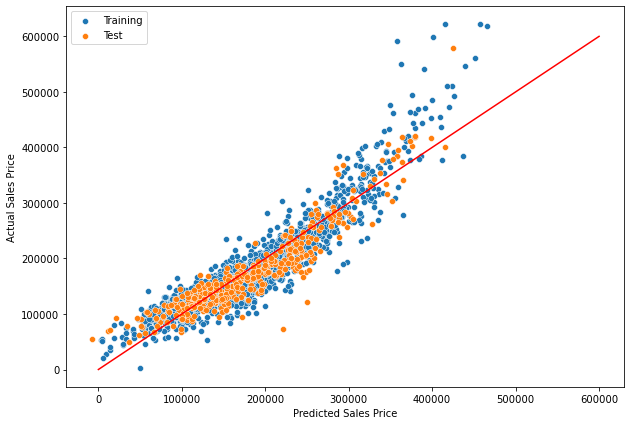

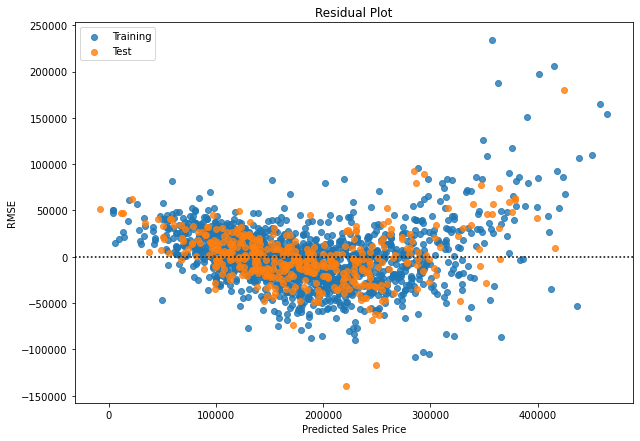

Initial Best Alpha 50.0
Improved Best Alpha 60.0
Training and Test Error: 31069.98 29598.0


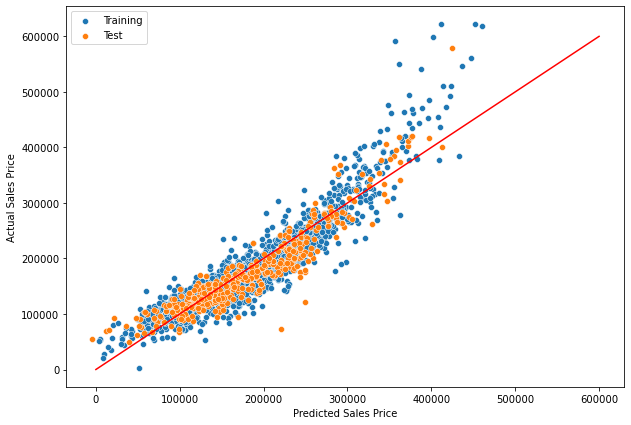

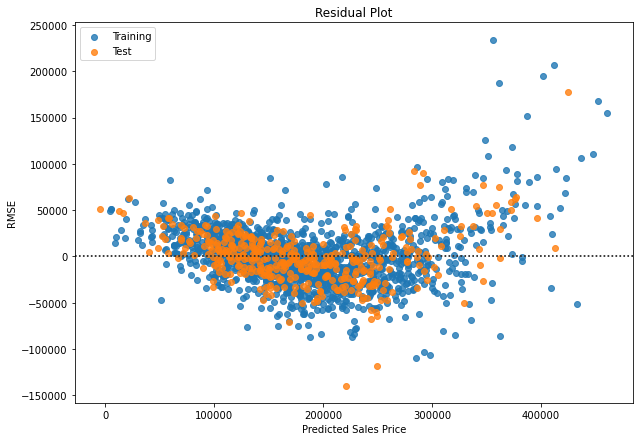

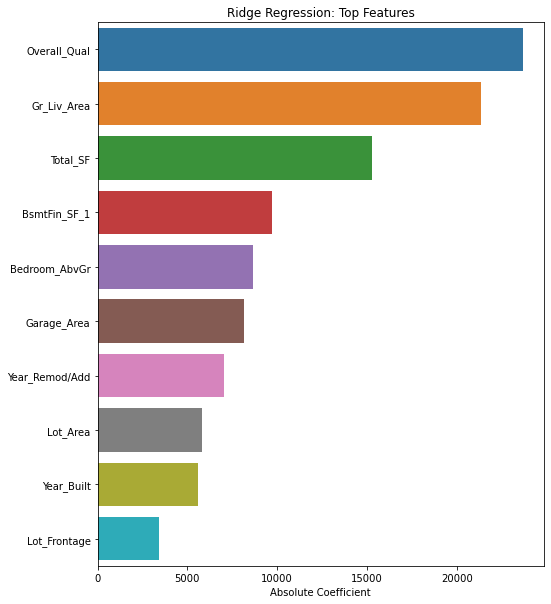

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605187918171.8728, tolerance: 831268931.4165038
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 643233981074.477, tolerance: 895104701.8888875
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599882112270.6466, tolerance: 821774594.2901276
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Initial Best Alpha 1000.0
Improved Best Alpha 931.73
Training and Test Error: 31137.86 29585.84


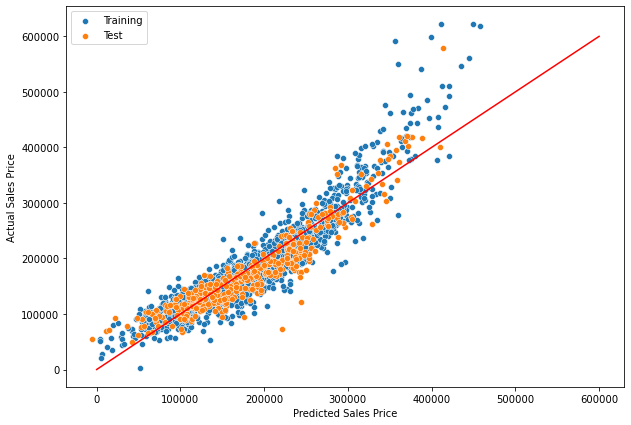

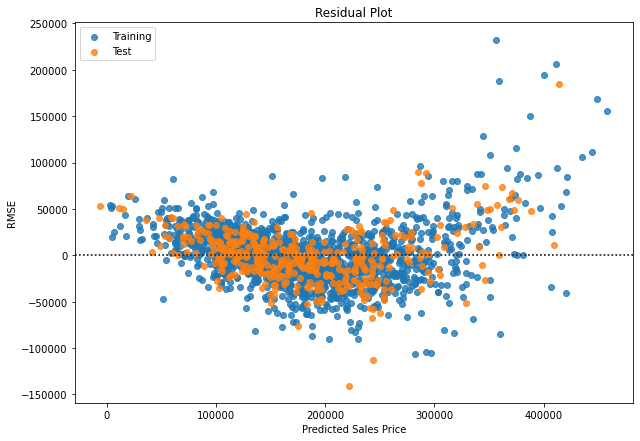

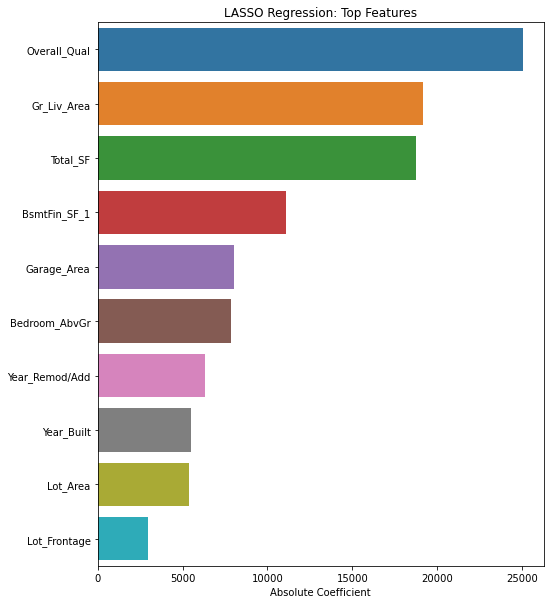

In [33]:
#RF
runmodels(training_data, test_data, numfeaturesrf, idxrf)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     502.1
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:13:24   Log-Likelihood:                -18784.
No. Observations:                1598   AIC:                         3.761e+04
Df Residuals:                    1578   BIC:                         3.772e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.79e+05   1866.246     95.906

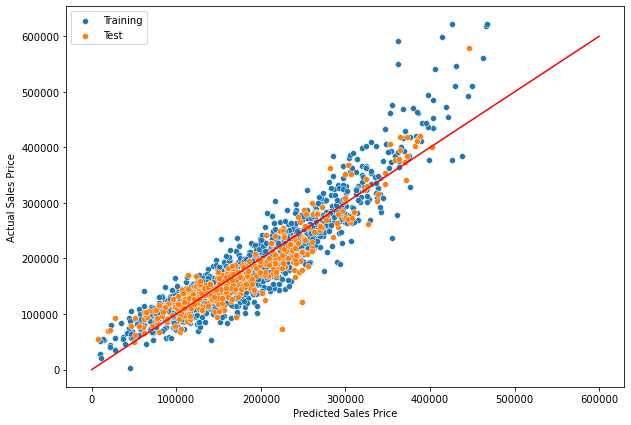

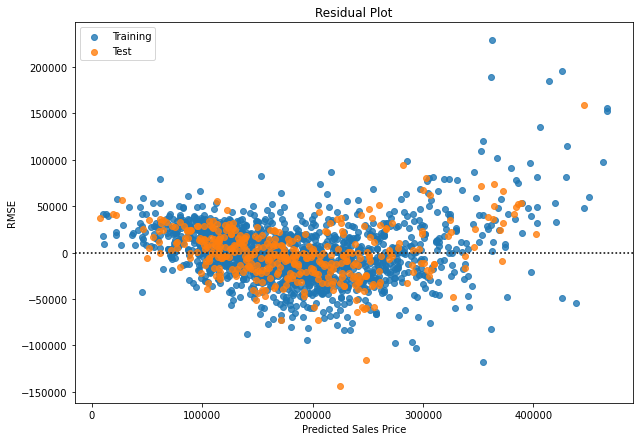

Initial Best Alpha 100.0
Improved Best Alpha 82.01
Training and Test Error: 30884.18 29109.2


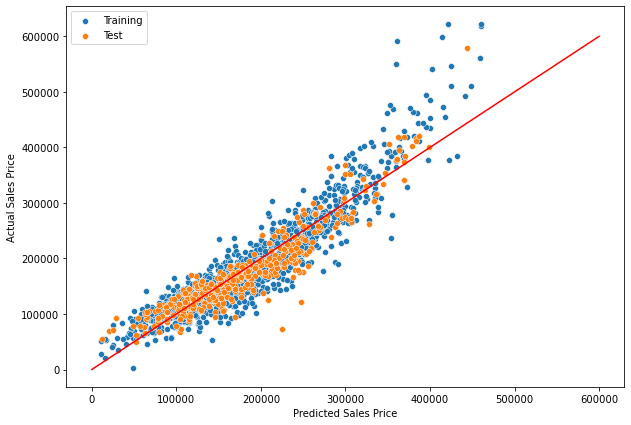

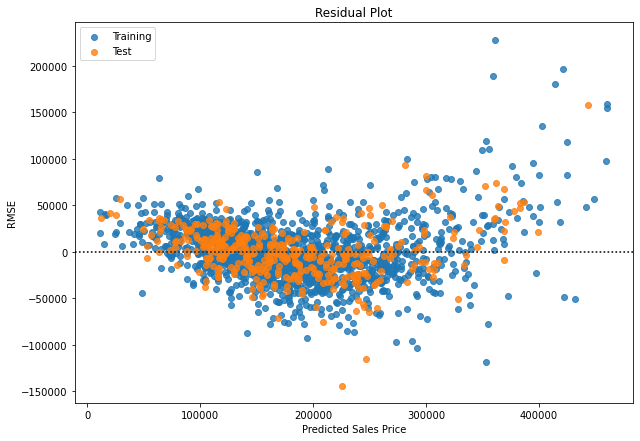

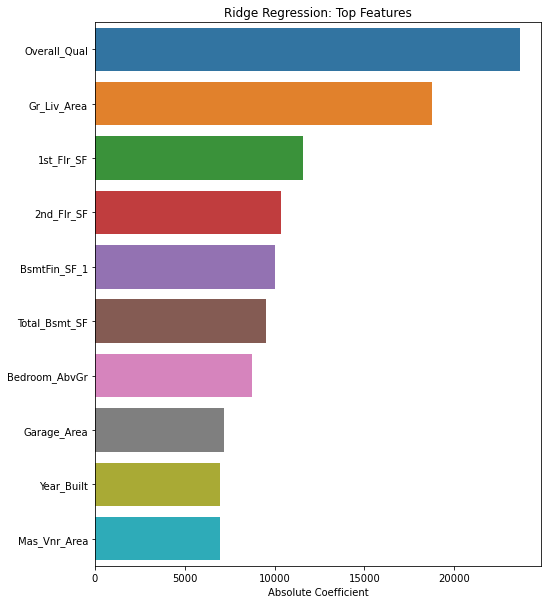

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416172230250.03577, tolerance: 831268931.4165038
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306058623630.60535, tolerance: 895104701.8888875
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4067807370.511841, tolerance: 821774594.2901276
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Initial Best Alpha 1000.0
Improved Best Alpha 978.98
Training and Test Error: 30958.2 29093.92


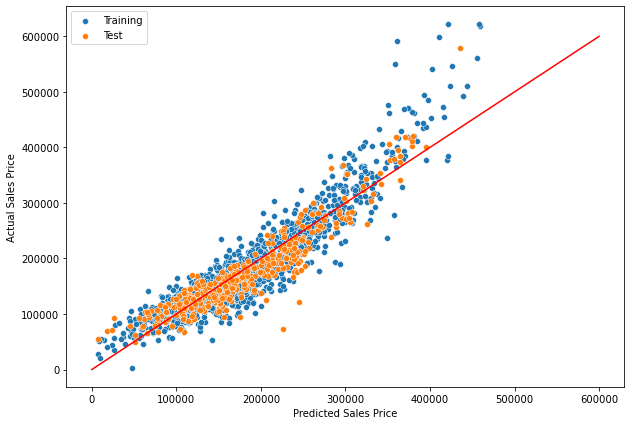

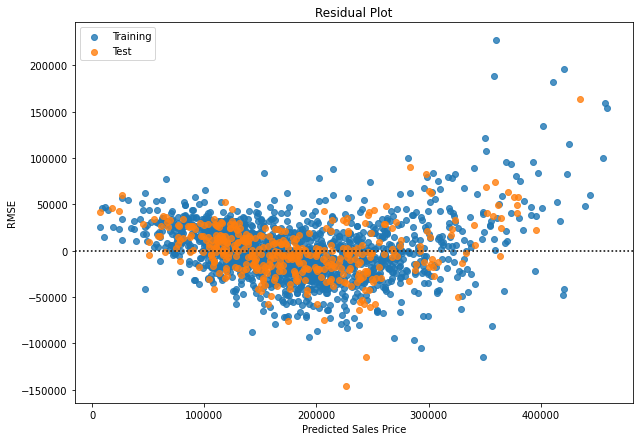

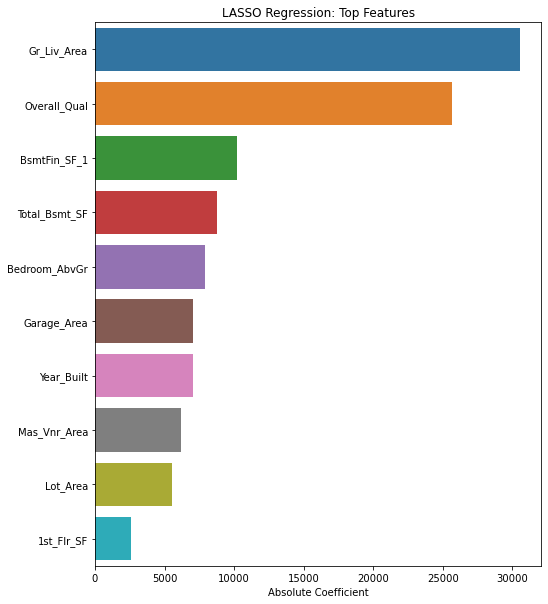

In [34]:
#GB
runmodels(training_data, test_data, numfeaturesgb, idxgb)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     569.1
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:13:55   Log-Likelihood:                -18862.
No. Observations:                1598   AIC:                         3.776e+04
Df Residuals:                    1582   BIC:                         3.784e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.815e+05    813.430    223.

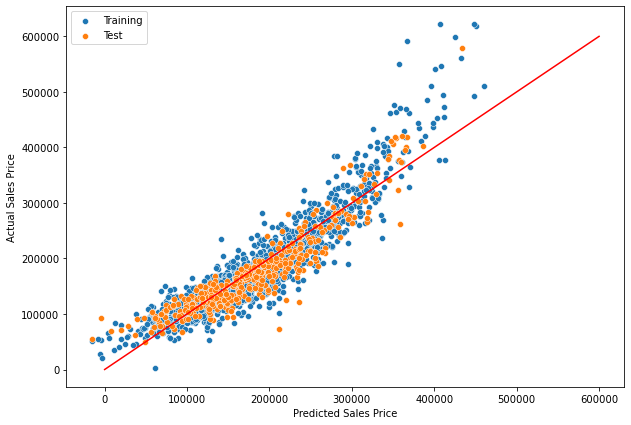

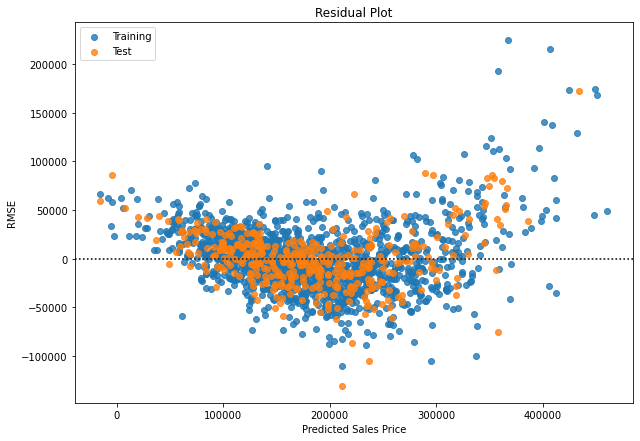

Initial Best Alpha 10.0
Improved Best Alpha 12.0
Training and Test Error: 32354.98 30963.95


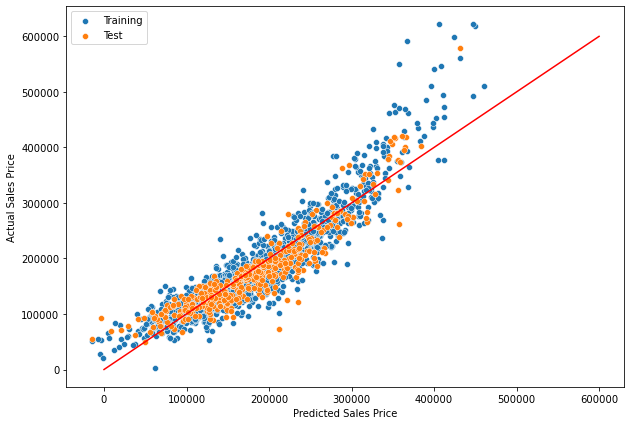

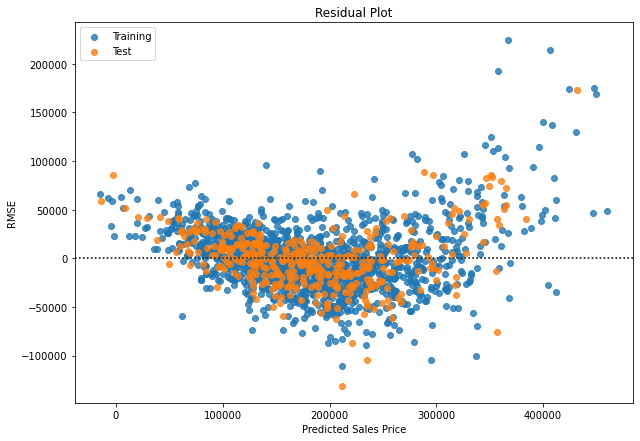

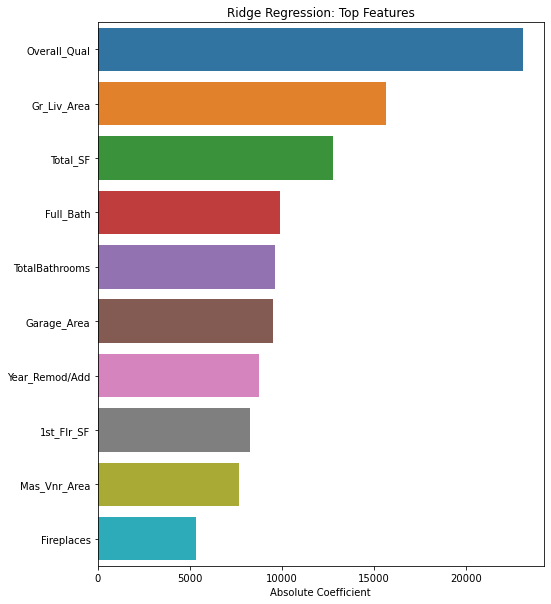

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 671180167120.9849, tolerance: 831268931.4165038
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 695142332987.9098, tolerance: 895104701.8888875
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 656019009172.0785, tolerance: 821774594.2901276
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Initial Best Alpha 100.0


C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9556467022.5896, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9557093409.748047, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9557676314.501709, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9574104409.656006, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1086597192.2419434, tolerance: 895104701.8888875
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9574682971.919434, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9589774315.895996, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9590525772.981445, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9591100419.700684, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9613317770.019287, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9614092810.646729, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9614867708.672607, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9636154092.90747, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9636923646.912354, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9637693057.811768, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9660314733.3208, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9661078482.147705, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9661778937.769287, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9683134975.138916, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9683809249.247803, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9684565915.20288, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9706719184.358398, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9707470106.31128, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9708220883.140625, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9730154232.30542, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9730899232.255371, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9731644086.58667, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9751877403.151123, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9752616739.993164, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9753355930.6958, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9773388938.096924, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9774122580.469482, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9774856076.200684, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9794687379.565186, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9795415296.111084, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9796143065.514404, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9815771269.945068, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9816493429.318848, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9817215441.036865, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9837355522.42041, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9838071745.102783, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9838787819.637451, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9858000117.608887, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9858710519.910645, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9859420773.544434, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9880538961.051025, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9881243064.115967, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9881947018.019531, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9902122822.46045, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9902820741.572266, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9903518511.013184, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9922768599.167969, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9923460451.131104, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9924152152.904053, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9942492936.072998, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9943178839.192383, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9943864591.63916, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1333421763.5063477, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1228371892.958252, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1126666602.442627, tolerance: 859516305.1975329
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Improved Best Alpha 120.0
Training and Test Error: 32356.02 30965.13


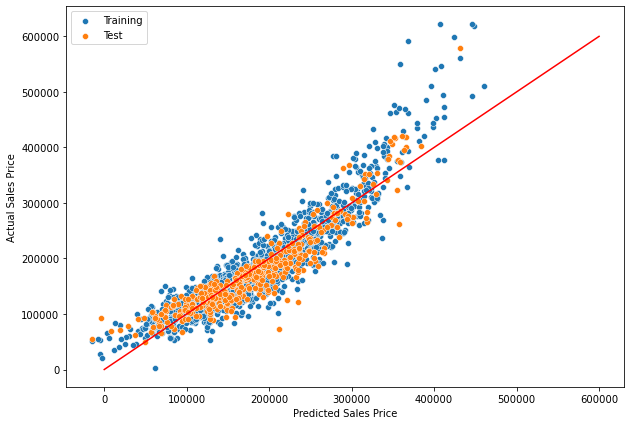

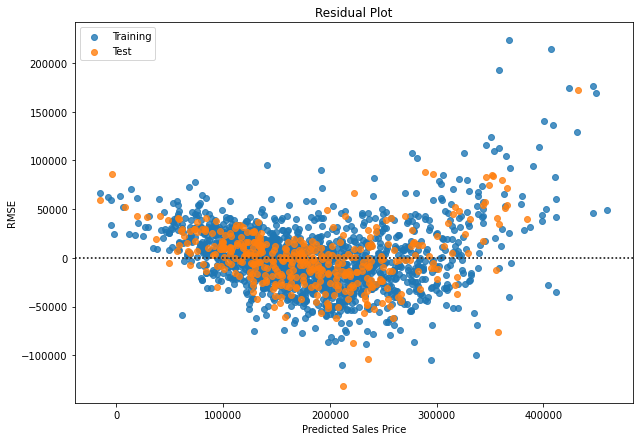

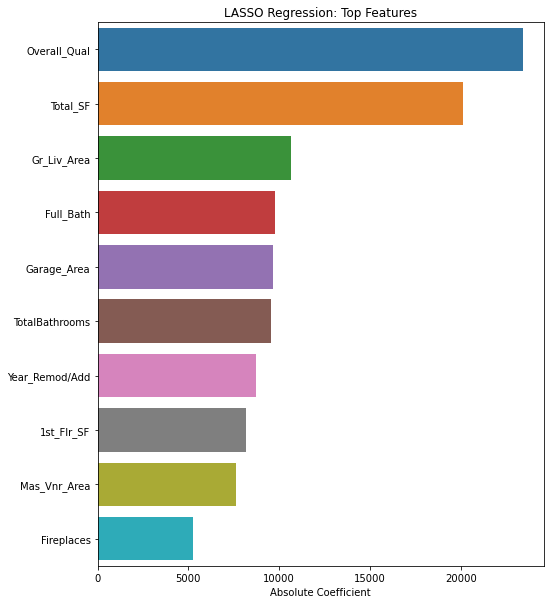

In [35]:
#corr
runmodels(training_data, test_data, numfeaturescorr, idxcorr)

# Conclusion

In the end, we determined that using 9 numberical variables was optimal for our regression. A few categorical variables were added that would intuitively correlate to the sales price and improve our model. 

Areas of improvement for our model including trying to find a method that determines the best categorical variables to use, as only three were used in this notebook. Adding more categorical variables that are highly correlated to the sales price would help fit our data better to our chosen model and reduce test errors. It would also be helpful to further address a few outliers which was throwing off our regression. Perhaps using a different type of model would help accrurately predict the sales price of houses.